# Data Cleaning


The goal of this document is to show the process in which the data is transformed from the KT3 dataset into the format that will be used to answer the overall research quesiton:\
\
**How does the time spent on lectures impact the performance of students in online courses?**

In [67]:
import csv, os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [68]:
BASE_DIR = os.path.dirname(os.getcwd())

In [69]:
DATASET_PATH = os.path.join(BASE_DIR,"dataset","KT3")
CLEAN_DATASET_PATH = os.path.join(BASE_DIR,"cleaned_dataset")
CLEAN_DATASET_CSV_PATH = os.path.join(CLEAN_DATASET_PATH,"dataset.csv")

Here, the structure of where and how question answer data is stored is explored to extract the question answer to compare to the correct answer later on. From the exploration below, a few key takeaways can be inferred.

1. Question rows lie between rows detailing the opening and closing of a bundle. 
2. Bundles have one question each, but not all bundles contain questions. 
3. There can be multiple instances of one question, but only the last one counts when the problem is submitted.

In [70]:
for file_name in random.sample(os.listdir(DATASET_PATH),10):
    with open(os.path.join(DATASET_PATH,file_name),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header

        bundle_flag = 0
        to_print = dict()
        for line in reader:
            if line[2][0] == "b":
                bundle_flag = ~bundle_flag
                if not bundle_flag and len(to_print):
                    print(f'''Bundle {line[2]} contains questions {",".join([f"{value} instances of {key}" for key,value in to_print.items()])}''')
                    to_print = dict()
            if line[2][0] == "q" and bundle_flag:
                if not to_print.get(line[2],0):
                    to_print[line[2]] = 0
                to_print[line[2]] += 1


Bundle b3011 contains questions 1 instances of q4479
Bundle b924 contains questions 1 instances of q924
Bundle b3351 contains questions 1 instances of q4819
Bundle b3587 contains questions 1 instances of q5055
Bundle b2229 contains questions 1 instances of q3697
Bundle b190 contains questions 1 instances of q190
Bundle b7371 contains questions 1 instances of q10020
Bundle b2482 contains questions 1 instances of q3950
Bundle b4004 contains questions 1 instances of q5472
Bundle b5531 contains questions 1 instances of q8060
Bundle b5632 contains questions 1 instances of q8161
Bundle b2557 contains questions 1 instances of q4025
Bundle b4272 contains questions 1 instances of q5740
Bundle b4337 contains questions 1 instances of q5805
Bundle b2667 contains questions 1 instances of q4135
Bundle b4096 contains questions 1 instances of q5564
Bundle b2165 contains questions 1 instances of q3633
Bundle b4743 contains questions 1 instances of q6211
Bundle b3131 contains questions 1 instances of q4

Lectures are more straightforward. Opening a lecture follows with a row closing this lecture. Thus, to calculate the average time each student spends on lectures, the difference between the timestamps of the intial row and the row below (entering and exiting row) can be found, then averaged later on.

In [71]:
for file_name in random.sample(os.listdir(DATASET_PATH),10):
    with open(os.path.join(DATASET_PATH,file_name),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header

        for line in reader:
            if line[2][0] == "l":
                next_line = next(reader)
                print(f"{line[2]} start, {next_line[2]} end, difference in time: {int(next_line[0]) - int(line[0])}")
        print("---")
                

---
---
---
---
---
---
---
---
---
---


One concern that the code above raises is that some users may not have any lecture time at all. Counting these data points as "0 hours of lecture" may be inaccurate, as there is no data on how much time the student spends on lectures as they do not spend it with the app. Therefore, these datapoints are excluded.

Students who do not answer any questions with the system similarly are data points without sufficient data, and are removed.

In [72]:
included_data = []
num_removed = 0
for file_name in os.listdir(DATASET_PATH):
    file_path = os.path.join(DATASET_PATH,file_name)
    with open(file_path,"r") as file:
        reader = csv.reader(file)
        #to skip file header
        next(reader)

        conditions = {"lectures":0,"questions":0}
        for line in reader:
            if line[2]:
                if line[2][0] == "l":
                    conditions["lectures"] = 1
                elif line[2][0] == "q":
                    conditions["questions"] = 1

        if all(conditions.values()):        
            included_data.append(file_name)
        else:num_removed += 1
                
num_removed

255427

In [73]:
included_data[:2]

['u485334.csv', 'u384503.csv']

After performing this step, the data is then transformed into a dataset with the format
- UserID: The id of the student
- Lecture Hours: The total number of hours spent on lectures represented in milliseconds
- Correct Percent: The percentage of historical lifetime questions answered correctly with the application

In [74]:
def transform_data(data):
    #create a key with questions and their corresponding correct answers
    question_key = {}
    with open(os.path.join(BASE_DIR,"dataset","questions.csv"),"r") as file:
        reader = csv.reader(file)
        next(reader) #for the header
        for line in reader:
            if str(line[3]) != "-1":
                question_key[line[0]] = line[3]

    to_return = {"UserID":[],"Lecture_Hours":[],"Correct_Percent":[]}

    for file_name in data:
        id = file_name[:file_name.index(".")]
        to_return["UserID"].append(id)
        with open(os.path.join(DATASET_PATH,file_name),"r") as file:
            reader = csv.reader(file)
            next(reader) #for the header

            question_lock = 0
            prev_line = []

            # assume this will never be 0/0 because the code above removes all students with no questions answered
            num_correct = 0
            total_questions = 0
            tot_lecture_time = 0

            for line in reader:
                if line[2]:
                    if question_lock and line[2][0] != "q":
                        total_questions += 1
                        num_correct += int(prev_line[4] == question_key[prev_line[2]])
                        question_lock = 0
                    if line[2][0] == "q":
                        question_lock = 1
                    if line[2][0] == "l":
                        next_line = next(reader)
                        tot_lecture_time += int(next_line[0]) - int(line[0])
                    prev_line = line
            #just in case the last line is a question answer
            if prev_line[2][0] == "q":
                total_questions += 1
                num_correct += int(prev_line[4] == question_key[prev_line[2]])

            to_return["Lecture_Hours"].append(tot_lecture_time)
            to_return["Correct_Percent"].append(num_correct / total_questions)
        
    to_return = pd.DataFrame(to_return)

    return to_return

In [75]:
if not os.path.exists(CLEAN_DATASET_CSV_PATH):
    df = transform_data(included_data)

In [76]:
df.head(5)

,UserID,Lecture_Hours,Correct_Percent
0,u485334,456389,0.754237
1,u384503,190414,0.675000
2,u525828,389228,0.708609
3,u329291,200190,0.391304
4,u12223,249467,0.750000


In [79]:
df.describe()

,Lecture_Hours,Correct_Percent
count,4.248800e+04,42488.000000
mean,4.688828e+06,0.606074
std,2.225739e+07,0.129110
min,6.400000e+01,0.000000
25%,2.182822e+05,0.545455
50%,7.027015e+05,0.628458
75%,2.915694e+06,0.691645
max,2.504055e+09,1.000000


<Axes: >

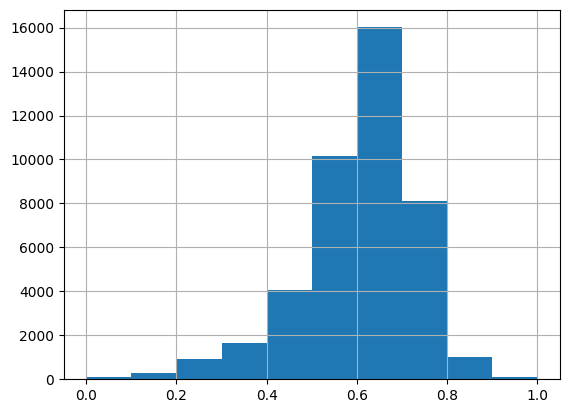

In [81]:
df["Correct_Percent"].hist()

<Axes: >

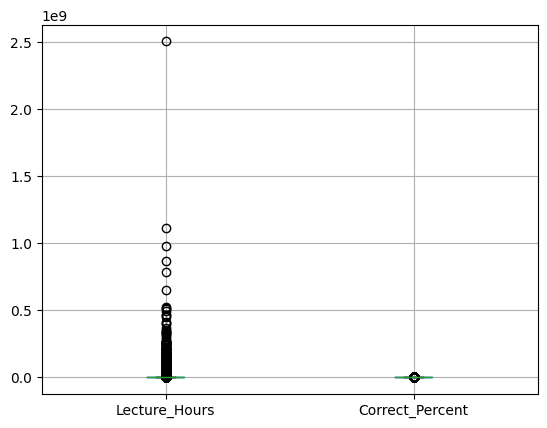

In [84]:
df.boxplot()